<a href="https://colab.research.google.com/github/AllergictoCrustaceans/ML/blob/main/binary_classification_autism_likelihood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Likelihood of Autism

Prompt: Given test scores and demographics from autism screening, determine the likelihood of autism of the patient.

Where is data from: https://www.kaggle.com/andrewmvd/autism-screening-on-adults

ML Problem Type: Binary Classification, Imbalanced Data

WARNING: If your API token ever expires, you need to go to: Runtime > Factory Reset Runtime > Run all

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

!pip install --upgrade --force-reinstall --no-deps kaggle

Processing /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10/kaggle-1.5.10-cp37-none-any.whl
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


### 1.) Load via Kaggle API Command

In [ ]:
from google.colab import files
files.upload() # Browse for the kaggle.json file that you downloaded

# Make directory named kaggle, copy kaggle.json file there, and change the permissions of the file.
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# You can check if everything's okay by running this command.
! kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                       title                                         size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  -------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
michau96/restaurant-business-rankings-2020                Restaurant Business Rankings 2020             16KB  2021-01-30 14:20:45           4215        125  1.0              
gpreda/reddit-wallstreetsbets-posts                       Reddit WallStreetBets Posts                    9MB  2021-02-28 06:57:50           1949        271  1.0              
yorkehead/stock-market-subreddits                         Stock Market Subreddits                        1MB  2021-01-29 13:53:50            387         20  1.0              
aagghh/crypto-telegram-groups                             Crypto telegram groups           

Since it's just a .csv, there's no need to unzip.

In [ ]:
!kaggle datasets download -d andrewmvd/autism-screening-on-adults --unzip

  0% 0.00/7.38k [00:00<?, ?B/s]
100% 7.38k/7.38k [00:00<00:00, 4.95MB/s]


In [54]:
# Load csv
ds_raw = pd.read_csv('/content/autism_screening.csv')

###2.) Inspect Data

In [55]:
ds_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704 entries, 0 to 703
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   A1_Score         704 non-null    int64  
 1   A2_Score         704 non-null    int64  
 2   A3_Score         704 non-null    int64  
 3   A4_Score         704 non-null    int64  
 4   A5_Score         704 non-null    int64  
 5   A6_Score         704 non-null    int64  
 6   A7_Score         704 non-null    int64  
 7   A8_Score         704 non-null    int64  
 8   A9_Score         704 non-null    int64  
 9   A10_Score        704 non-null    int64  
 10  age              702 non-null    float64
 11  gender           704 non-null    object 
 12  ethnicity        704 non-null    object 
 13  jundice          704 non-null    object 
 14  austim           704 non-null    object 
 15  contry_of_res    704 non-null    object 
 16  used_app_before  704 non-null    object 
 17  result          

Some things I notice immediately:
- Misspelled column name "jaundice". 
- Misspelled column name "austism". 
- There are 2 data values missing from the 'age' column. 

Features with 'Dtype' == 'object' are categorical features, while those with 'Dtype' == 'int64' are numerical. 

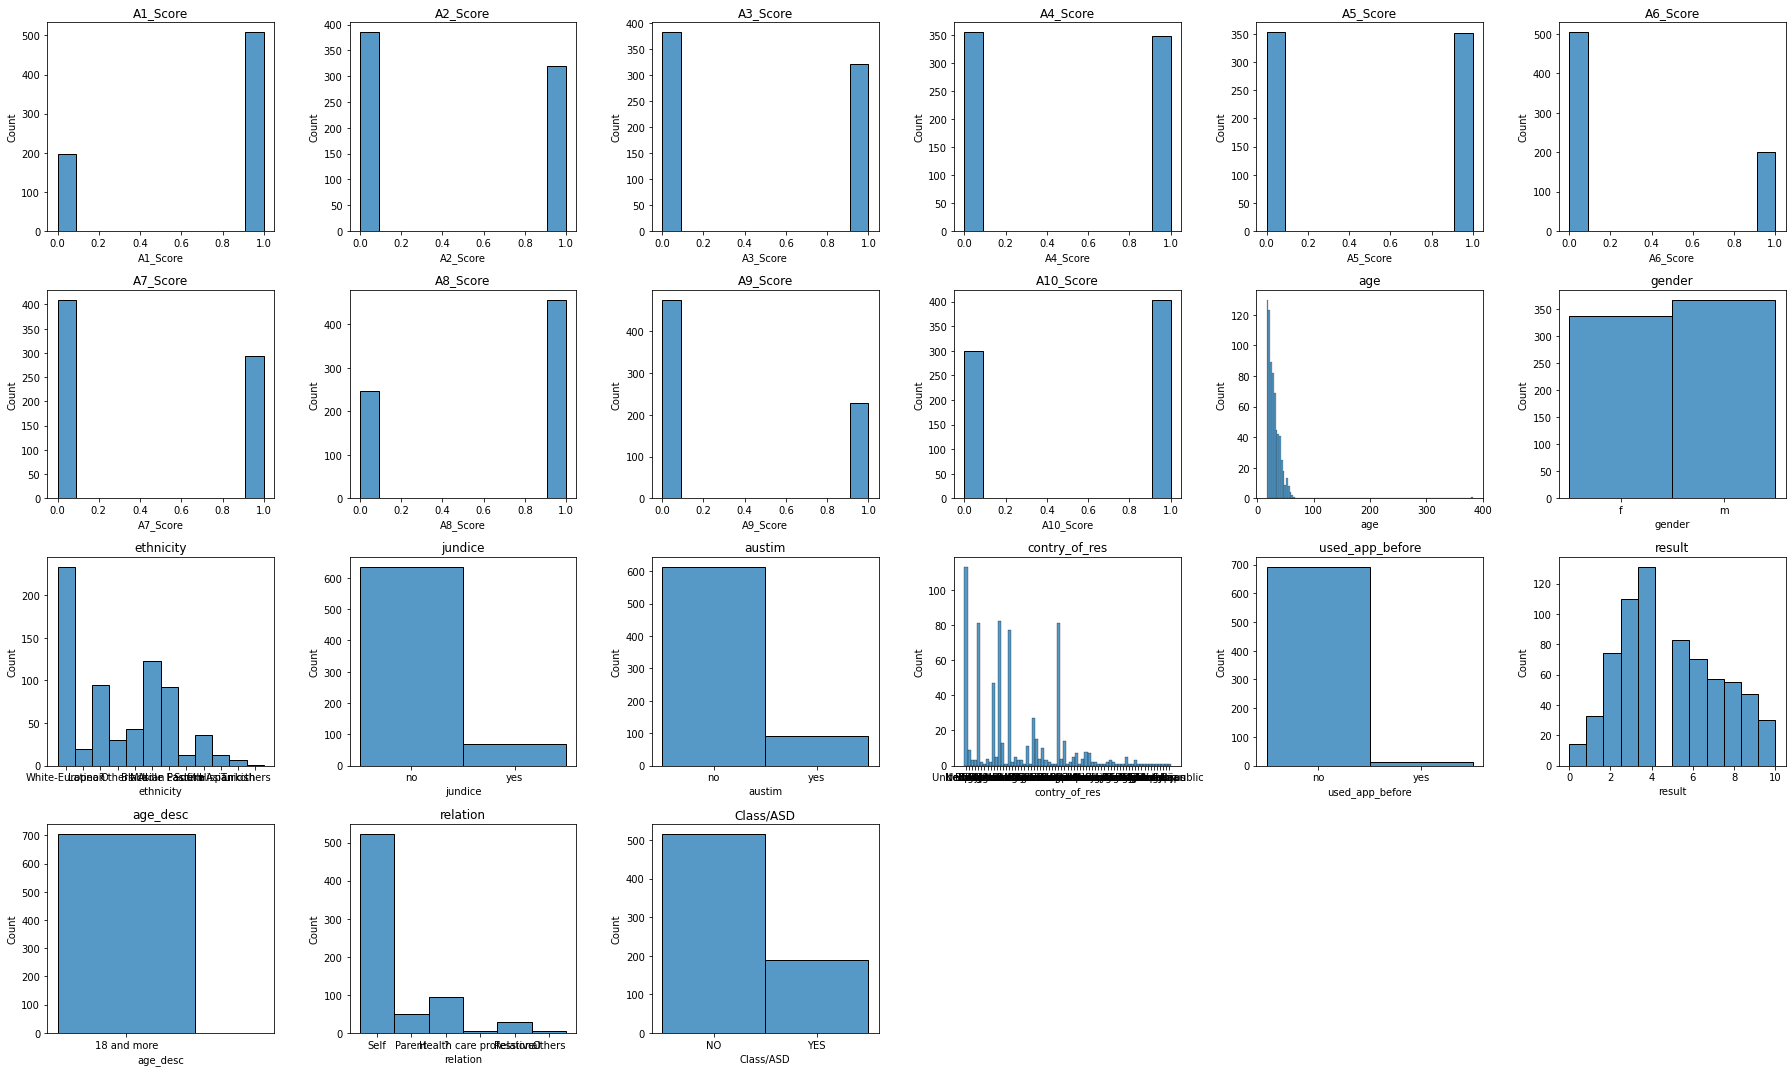

In [56]:
plt.figure(figsize=(25, 15))

for i, column in enumerate(ds_raw.columns):
    plt.subplot(4, 6, i+1)
    sns.histplot(data=ds_raw[column])
    plt.title(column)
    
plt.tight_layout()
plt.show()

The distributions above indicate that the test scores (e.g. A0, A1, A2, etc.) -- although numerical-- do behave in a categorical sense. For example, a value of 1 is a decisive indication of one thing associated to that A0 score Similarly, a value of 0 is a decisive indication of another thing associated to a particular A0 score.

Some things to notice:
-  Heavy right-skew in age, where most patients that took the survey are young. 
- The 'result' distribution doesn't have anybody scoring a 5 on their autism assessment. Why?
- The 'used_app_before' feature columns may not be helpful in predicting the likelihood of autism in a patient. So, keep in mind to drop this column.

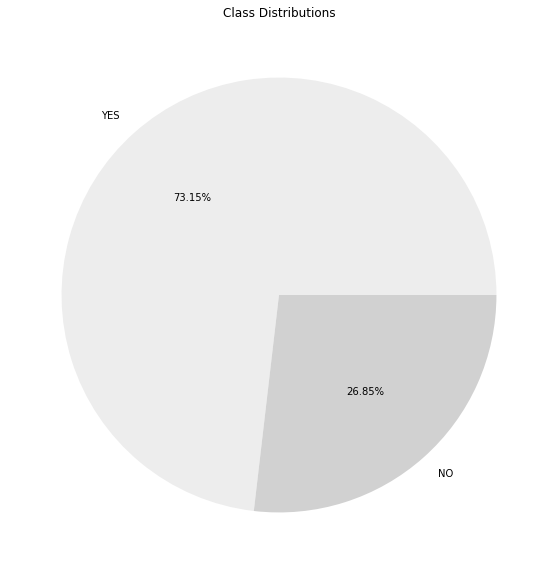

In [57]:
# Check for data imbalance

plt.figure(figsize=(10, 10))
plt.pie(ds_raw['Class/ASD'].value_counts(),
       autopct='%0.2f%%',
       labels=['YES', 'NO'],
       colors=sns.color_palette('Greys'))

plt.title('Class Distributions')
plt.show()

### 2.) Clean

Despite the categorical features given in the dataset, I will only use two categorical features ('jaundice', 'autism'), and one numerical feature ('result') to train the model in predicting autism likelihood (e.g. binary classification). 

In [58]:
ds = ds_raw.copy()
ds_simplified = ds.filter(['jundice', 'austim', 'result', 'Class/ASD'])
ds_simplified.columns = ['jaundice', 'autism', 'result', 'Class/ASD']

In [59]:
# Drop labels in X. Only use label in y.
X = ds_simplified.drop('Class/ASD', axis=1)
y = ds_simplified['Class/ASD']

### 3.) Split

In [60]:
train_df, test_df = train_test_split(ds_simplified, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

y_train = np.array(train_df.pop('Class/ASD'))
bool_y_train = y_train != 0
y_val = np.array(val_df.pop('Class/ASD'))
y_test = np.array(test_df.pop('Class/ASD'))

x_train = np.array(train_df)
x_val = np.array(val_df)
x_test = np.array(test_df)

### 4.) Preprocess 

In [61]:
# One hot encode, fit and transform x_train, x_test
ohe = OneHotEncoder(handle_unknown='ignore')
x_train = ohe.fit_transform(x_train)
x_test = ohe.fit_transform(x_test)
x_val = ohe.fit_transform(x_val)

# Label encode, fit, and transform y_train, y_test
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_val = le.fit_transform(y_val)

In [62]:
# Check datasets' shapes
x_train.shape, x_test.shape, y_train.shape, y_test.shape, x_val.shape, y_val.shape

((450, 15), (141, 15), (450,), (141,), (113, 15), (113,))

### Imbalanced Dataset

#### Build Model

In [63]:
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc')
]

def build(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(16, activation='relu', input_shape=(x_train.shape[-1],)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(lr=1e-3),
                 loss=keras.losses.BinaryCrossentropy(),
                 metrics=metrics)
    
    return model


EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

#### Train Model

In [64]:
plain_model = build()
plain_history = plain_model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(x_val, y_val))

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.8339 - tp: 81.0000 - fp: 292.0000 - tn: 40.0000 - fn: 37.0000 - accuracy: 0.2689 - precision: 0.2172 - recall: 0.6864 - auc: 0.3686 - val_loss: 0.8276 - val_tp: 21.0000 - val_fp: 82.0000 - val_tn: 1.0000 - val_fn: 9.0000 - val_accuracy: 0.1947 - val_precision: 0.2039 - val_recall: 0.7000 - val_auc: 0.2574
Epoch 2/100
1/1 [==============================] - 0s 39ms/step - loss: 0.8163 - tp: 83.0000 - fp: 275.0000 - tn: 57.0000 - fn: 35.0000 - accuracy: 0.3111 - precision: 0.2318 - recall: 0.7034 - auc: 0.4084 - val_loss: 0.8226 - val_tp: 21.0000 - val_fp: 82.0000 - val_tn: 1.0000 - val_fn: 9.0000 - val_accuracy: 0.1947 - val_precision: 0.2039 - val_recall: 0.7000 - val_auc: 0.2576
Epoch 3/100
1/1 [==============================] - 0s 40ms/step - loss: 0.8134 - tp: 87.0000 - fp: 266.0000 - tn: 66.0000 - fn: 31.0000 - accuracy: 0.3400 - precision: 0.2465 - recall: 0.7373 - auc: 0.4240 - val_loss: 0.8177 - val_tp: 21.00

#### Evaluate Loss V. Acc Plots, Confusion Matrix

Define helper functions of loss curves, and confusion matrix.

In [65]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')


def plot_metrics(history):
    metrics = ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                    color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

    plt.legend()


def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))


def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

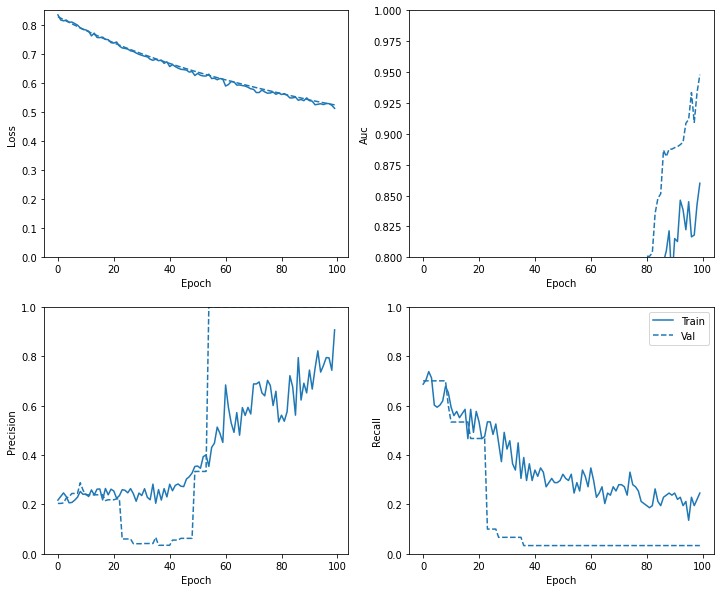

In [66]:
plot_metrics(plain_history)

From speculation of graph: 

**Loss:** Both training and val loss are making a slow descent as the number of epochs increase. The training and val loss values seems to be quite close together too. 

**Precision:** The training precision looks very volatile as the number of epochs increase. 

**Recall:** Recall w.r.t. training dataset slowly steepens as the number of epochs increase. 

In [67]:
train_predictions_baseline = plain_model.predict(x_train, batch_size=BATCH_SIZE)
test_predictions_baseline = plain_model.predict(x_test, batch_size=BATCH_SIZE)

loss :  0.528734028339386
tp :  6.0
fp :  0.0
tn :  100.0
fn :  35.0
accuracy :  0.7517730593681335
precision :  1.0
recall :  0.1463414579629898
auc :  0.9413414001464844

Legitimate Transactions Detected (True Negatives):  100
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  35
Fraudulent Transactions Detected (True Positives):  6
Total Fraudulent Transactions:  41


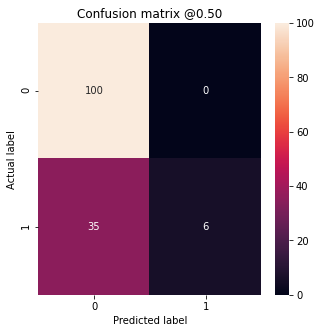

In [68]:
plain_results = plain_model.evaluate(x_test, y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, plain_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

**True Positive**: The model correctly predicted 6 for the positive class, meaning the model correctly predicted 6 data samples likely having autism. 

**True Negative**: The model correctly predicted 100 data samples for the negative class, menaing the model predicted correctly that 100 data samples are indeed not likely of having autism.

**False Positive**: The model incorrectly predicted NONE for the positive class, meaning the model did not mislabel/incorrectly predict any of the data samples of likely having autism. 

**False Negative**: The model incorrectly predicted 35 data samples of the negative class, meaning the model did mislabel/incorrectly predict 48 data samples of not likely having autism, when in reality, they do have autism.

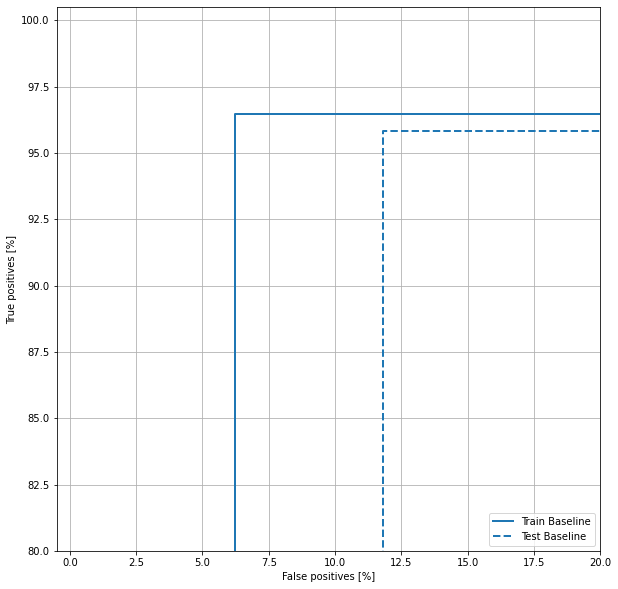

In [ ]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

Overall, even with 100 epochs, the model doesn't learn that well. I will attempt to resolve this by using data balancing techniques to see whether they can optimize the model training. 

### Balance Dataset w/ Added Weights

#### Build Model

In [69]:
count = ds_raw['Class/ASD'].value_counts()
print(count)

NO     515
YES    189
Name: Class/ASD, dtype: int64


In [70]:
neg = 515
pos = 189
total = neg + pos

In [71]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.68
Weight for class 1: 1.86


In [72]:
weighted_model = build()

####  Train Model

In [73]:
weighted_history = weighted_model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(x_val, y_val),
    # The class weights go here
    class_weight=class_weight)

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.7261 - tp: 7.0000 - fp: 2.0000 - tn: 430.0000 - fn: 152.0000 - accuracy: 0.7394 - precision: 0.7778 - recall: 0.0440 - auc: 0.7235 - val_loss: 0.5776 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 82.0000 - val_fn: 30.0000 - val_accuracy: 0.7257 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7253
Epoch 2/100
1/1 [==============================] - 0s 55ms/step - loss: 0.7215 - tp: 2.0000 - fp: 3.0000 - tn: 329.0000 - fn: 116.0000 - accuracy: 0.7356 - precision: 0.4000 - recall: 0.0169 - auc: 0.6685 - val_loss: 0.5767 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 82.0000 - val_fn: 30.0000 - val_accuracy: 0.7257 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7369
Epoch 3/100
1/1 [==============================] - 0s 57ms/step - loss: 0.7308 - tp: 2.0000 - fp: 2.0000 - tn: 330.0000 - fn: 116.0000 - accuracy: 0.7378 - precision: 0.5000 - recall: 0.0169 - auc: 0.6347 - val_loss: 0

#### Evaluate Model

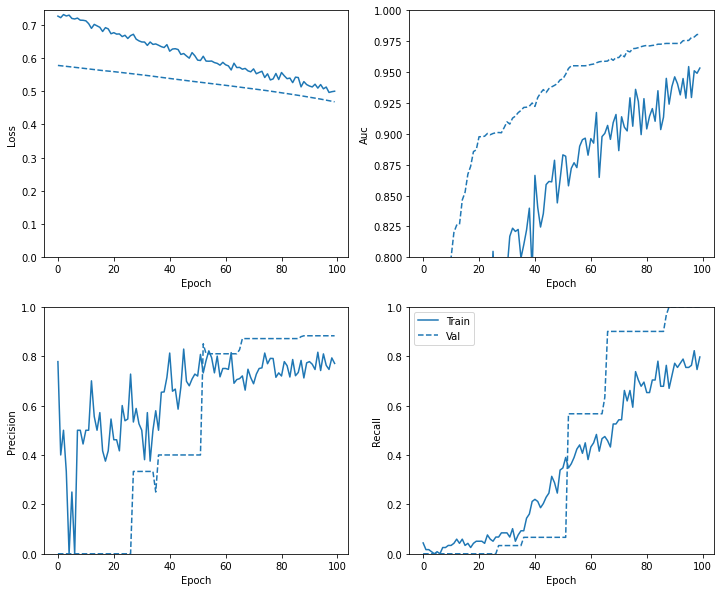

In [74]:
plot_metrics(weighted_history)

From graph speculation:

Loss: The training and val loss still doesn't quite seem to decrease quickly. Training and val loss still seem close together. This could be due to the small dataset size, resulting in high bias. 

Precision: The training dataset's precisons seems to hover around 0.7 and 0.8, while val dataset's precicion value hovers above 0.8. 

Recall: The training dataset's recall gradually increase as the number of epoch interations increase. Similarly, the val dataset's recall value increases too. The only difference if the val dataset's precision soars higher than that of the training dataset's precision at epoch 50.

In [75]:
train_predictions_weighted = weighted_model.predict(x_train, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(x_test, batch_size=BATCH_SIZE)

loss :  0.4604305624961853
tp :  33.0
fp :  3.0
tn :  97.0
fn :  8.0
accuracy :  0.9219858050346375
precision :  0.9166666865348816
recall :  0.8048780560493469
auc :  0.9898780584335327

Legitimate Transactions Detected (True Negatives):  97
Legitimate Transactions Incorrectly Detected (False Positives):  3
Fraudulent Transactions Missed (False Negatives):  8
Fraudulent Transactions Detected (True Positives):  33
Total Fraudulent Transactions:  41


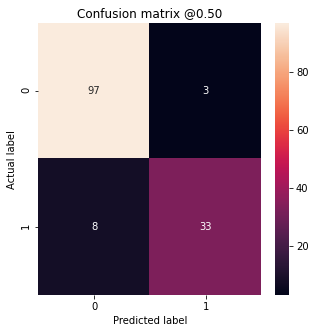

In [76]:
weighted_results = weighted_model.evaluate(x_test, y_test,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_weighted)

Despite having a high accuracy rate (> 90%), a lower loss value (0.46) that's lower than the previous trained model (0.52), and less false postives and negatives, this still may not indicate a good model. 

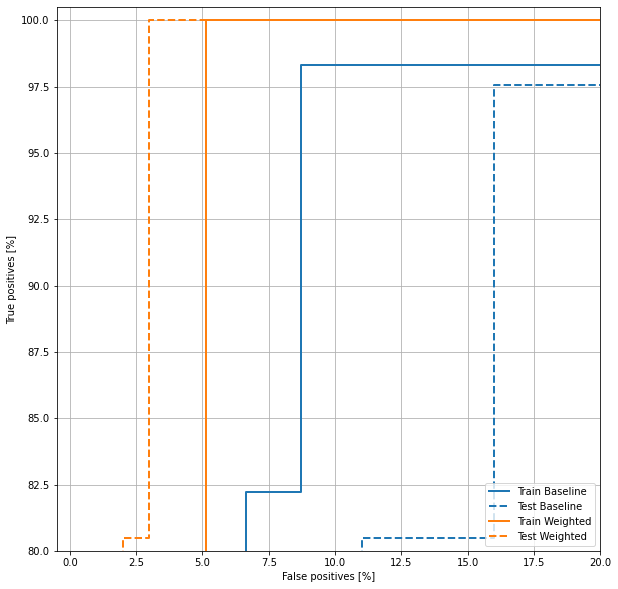

In [77]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

Overall, adding weights helped improve the model a little bit. Next, I will attempt to balance the dataset by oversampling the minority group. Hopefully, this will improve the training. 

### Balance Dataset via Oversampling Minority Label

#### Resample Dataset

In [78]:
pos_features = x_train[bool_y_train].toarray()
neg_features = x_train[~bool_y_train].toarray()

pos_labels = y_train[bool_y_train]
neg_labels = y_train[~bool_y_train]

In [79]:
BUFFER_SIZE = 100

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [80]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]

Label:  0


In [81]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [82]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.26171875


In [83]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

1.0

#### Build

In [84]:
resampled_model = build()

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

<tf.Variable 'UnreadVariable' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>

#### Train

In [85]:
resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=(x_val, y_val))

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.6370 - tp: 352.0000 - fp: 471.0000 - tn: 1148.0000 - fn: 218.0000 - accuracy: 0.6852 - precision: 0.4277 - recall: 0.6175 - auc: 0.7234 - val_loss: 0.6204 - val_tp: 16.0000 - val_fp: 6.0000 - val_tn: 77.0000 - val_fn: 14.0000 - val_accuracy: 0.8230 - val_precision: 0.7273 - val_recall: 0.5333 - val_auc: 0.7213
Epoch 2/100
1/1 [==============================] - 0s 62ms/step - loss: 0.6302 - tp: 322.0000 - fp: 399.0000 - tn: 1108.0000 - fn: 219.0000 - accuracy: 0.6982 - precision: 0.4466 - recall: 0.5952 - auc: 0.7057 - val_loss: 0.6164 - val_tp: 16.0000 - val_fp: 6.0000 - val_tn: 77.0000 - val_fn: 14.0000 - val_accuracy: 0.8230 - val_precision: 0.7273 - val_recall: 0.5333 - val_auc: 0.7269
Epoch 3/100
1/1 [==============================] - 0s 63ms/step - loss: 0.6272 - tp: 315.0000 - fp: 382.0000 - tn: 1124.0000 - fn: 227.0000 - accuracy: 0.7026 - precision: 0.4519 - recall: 0.5812 - auc: 0.7041 - val_loss: 0.6124 -

#### Evaluate

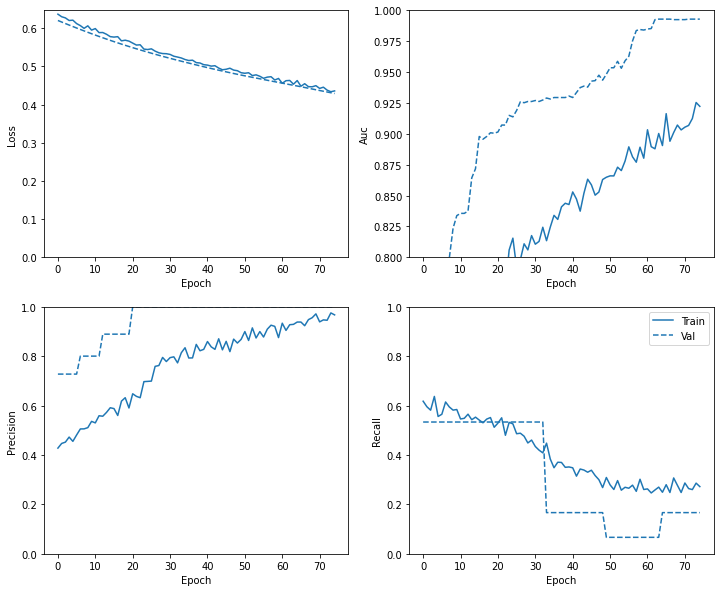

In [86]:
plot_metrics(resampled_history)

In [87]:
train_predictions_resampled = resampled_model.predict(x_train, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(x_test, batch_size=BATCH_SIZE)

loss :  0.4552352726459503
tp :  11.0
fp :  0.0
tn :  100.0
fn :  30.0
accuracy :  0.7872340679168701
precision :  1.0
recall :  0.26829269528388977
auc :  0.9858536720275879

Legitimate Transactions Detected (True Negatives):  100
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  30
Fraudulent Transactions Detected (True Positives):  11
Total Fraudulent Transactions:  41


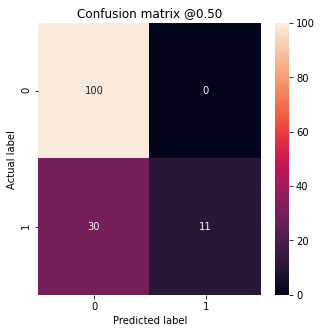

In [88]:
resampled_results = resampled_model.evaluate(x_test, y_test,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_resampled)

The loss value in this model is slightly less than the previous model (w/ added weights).

In this model, there are way more False Negatives than any of the previous two models. This may indicate that the model isn't learning how to properly classify which data samples likely have autism, based on the features it's learning from. 

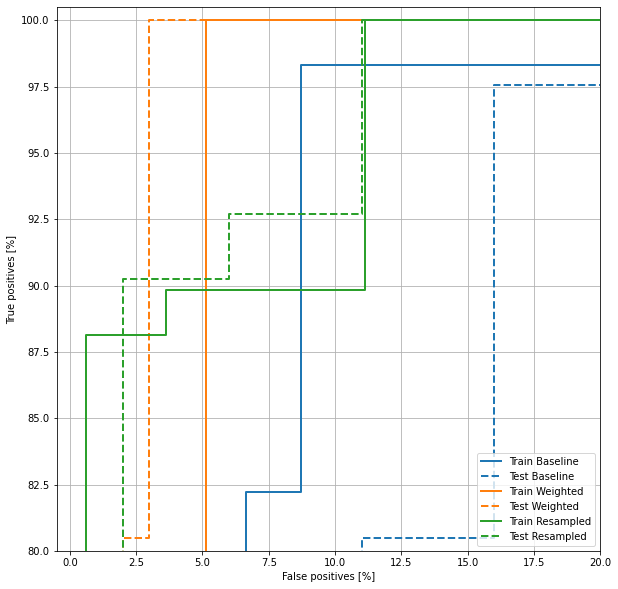

In [89]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", y_train, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", y_test, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')

Overall, my attempt at trying to balance the small dataset did not really help improve model performance. Some things I may consider to make this better:
- Collect more data to offset high bias
- Try training with other features.
- Try clustering, see if this gives any different insights of how what features may hold more weight in determining the likelihood of autism. 